# ML experiment: age

Set-up:
- we aim to get a first benchmark of how good can our ML predictions be for new problems and set-ups
- we have about ~1M datapoints per experiment, which is about a 1/10 of the PLOS paper
- we will use only buildings and blocks as urban form information, but they were the most predictive set of features for height prediction
- we are using two buffer sizes, 100m and 500m
- here we have some new features that we never tried previously, and we can explore whether age/type/floors/height are predictive of each other

Procedure:
- train 5 models with 2D geometrical features on n-1 regions, predicting on the last one, report the results
- train 5 models with all features (includes type, floors, height) on n-1 regions, predicting on the last one, report the results
- try possible hacks to improve the results
    - cutting outliers (e.g. below 1800)
    - making the problem simpler...
- copy paste the code below for each region/experiment so that we save all the prints
- plots/analysis of the results
- report individual results and average results for each region/experiment in a table

In [173]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn import metrics
import xgboost

In [145]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

We set the main variables. We aim to cross-validate our results using five French sub-regions 'departement' listed below.

In [27]:
path_input = r'E:\first-exp\all_age.csv'

In [30]:
region_names = ['Haute-Vienne','Hauts-de-Seine','Aisne','Orne','Pyrénées-Orientales']

In [78]:
aux_cols = ['ID','USAGE2','PREC_ALTI', 'NB_LOGTS','MAT_TOITS','MAT_MURS', 'geometry','city','departement','is_buffer','TouchesIndexes']

In [48]:
other_attributes_cols = ['USAGE1','NB_ETAGES','HAUTEUR']

The five departements are spatial distant. We will repeat an experiment where we train on 4 and predict on 5th, to see if we manage to generalize across regions.

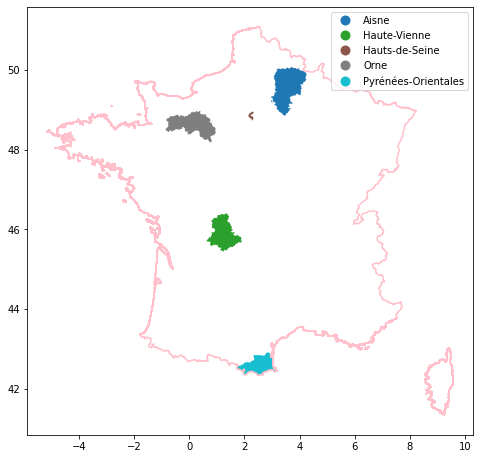

In [25]:
# dont run this cell if you dont want the map to disappear

# GDAM0=gpd.read_file(r'E:\ML_paper\Data\1-data_primary\GADM\France\gadm36_FRA_0.shp')
# GDAM2=gpd.read_file(r'E:\ML_paper\Data\1-data_primary\GADM\France\gadm36_FRA_2.shp')
# GDAM2=GDAM2[GDAM2.NAME_2.isin(region_names)]
# fig, ax = plt.subplots(figsize=(8,8))
# GDAM0.boundary.plot(ax=ax,color='pink')
# GDAM2.plot(ax=ax,column='NAME_2',legend=True)
# plt.show()

Let's import and preprocess the data. I have already removed all buildings that do not have age in the data.

In [79]:
# whole dataset
df_input = pd.read_csv(path_input)
len(df_input)

851843

In [80]:
# we take on region of validation
df_valid = df_input[df_input.departement==region_names[0]]
len(df_valid)

165698

In [81]:
# we use the rest for training
df_input = df_input[~df_input.index.isin(df_valid.index)]
len(df_input)

686145

This is the standard deviation in the validation set. This gives us an indication of a baseline. We want to be able to be substantially below that value.

In [96]:
df_valid.DATE_APP.std()

77.0042845044449

## First try

In [82]:
df_input = shuffle(df_input,random_state=0)
df_valid = shuffle(df_valid,random_state=0)

In [83]:
X_train = df_input.drop(columns=aux_cols+other_attributes_cols+['DATE_APP'])
y_train = df_input[['DATE_APP']]

In [84]:
X_valid = df_valid.drop(columns=aux_cols+other_attributes_cols+['DATE_APP'])
y_valid = df_valid[['DATE_APP']]

In [85]:
print((X_train.shape,y_train.shape,X_valid.shape,y_valid.shape))

((686145, 58), (686145, 1), (165698, 58), (165698, 1))


Here are our predictors.

In [153]:
X_train.columns

Index(['FootprintArea', 'Perimeter', 'Phi', 'LongestAxisLength', 'Elongation',
       'Convexity', 'Orientation', 'Corners', 'CountTouches',
       'SharedWallLength', 'BlockLength', 'AvBlockFootprintArea',
       'StdBlockFootprintArea', 'BlockTotalFootprintArea', 'BlockPerimeter',
       'BlockLongestAxisLength', 'BlockElongation', 'BlockConvexity',
       'BlockOrientation', 'BlockCorners', 'buildings_within_buffer_500',
       'total_ft_area_within_buffer_500',
       'av_footprint_area_within_buffer_500',
       'av_elongation_within_buffer_500', 'av_convexity_within_buffer_500',
       'av_orientation_within_buffer_500',
       'std_footprint_area_within_buffer_500',
       'std_elongation_within_buffer_500', 'std_convexity_within_buffer_500',
       'std_orientation_within_buffer_500', 'buildings_within_buffer_100',
       'total_ft_area_within_buffer_100',
       'av_footprint_area_within_buffer_100',
       'av_elongation_within_buffer_100', 'av_convexity_within_buffer_100',
 

Let's train first a linear model.

In [86]:
model = LinearRegression()

In [87]:
model.fit(X_train,y_train)

LinearRegression()

In [88]:
y_predict = model.predict(X_valid)

In [95]:
print('MAE: {} y'.format(metrics.mean_absolute_error(y_valid,y_predict)))
print('RMSE: {} y'.format(np.sqrt(metrics.mean_squared_error(y_valid,y_predict))))
print('R2: {}'.format(metrics.r2_score(y_valid,y_predict)))

MAE: 54.40748677699175 y
RMSE: 72.02916607582374 y
R2: 0.12503714818215217


Let's now train a regression tree.

In [97]:
model = xgboost.XGBRegressor()

In [98]:
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [99]:
y_predict = model.predict(X_valid)

In [100]:
print('MAE: {} y'.format(metrics.mean_absolute_error(y_valid,y_predict)))
print('RMSE: {} y'.format(np.sqrt(metrics.mean_squared_error(y_valid,y_predict))))
print('R2: {}'.format(metrics.r2_score(y_valid,y_predict)))

MAE: 45.68256423177209 y
RMSE: 65.18922982269473 y
R2: 0.2833212271400162


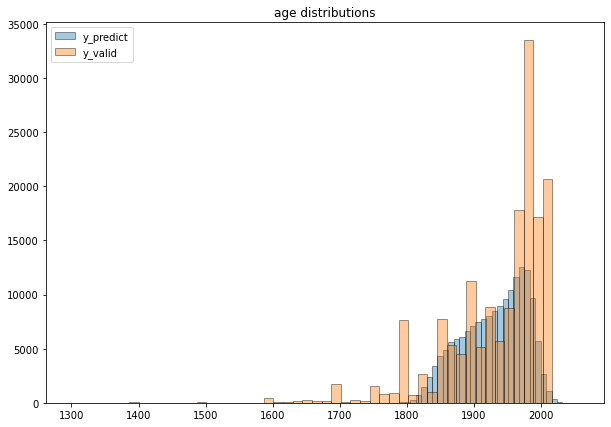

In [109]:
fig, ax = plt.subplots(figsize=(10,7))

sns.distplot(y_predict,ax=ax,
    hist=True,kde=False,
             hist_kws=dict(edgecolor="k", linewidth=1),
    label='y_predict')

sns.distplot(y_valid, ax=ax,
    hist=True,kde=False,
             hist_kws=dict(edgecolor="k", linewidth=1),
    label='y_valid')
# plt.xlim(0, 25)
ax.legend()
plt.title('age distributions')
plt.show()

In [124]:
df_valid = pd.DataFrame()
df_valid['y_predict'] = y_predict
df_valid['y_valid'] = y_valid

RangeIndex(start=0, stop=165698, step=1)

C:\Users\miln\AppData\Local\Continuum\anaconda3\envs\building-database\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

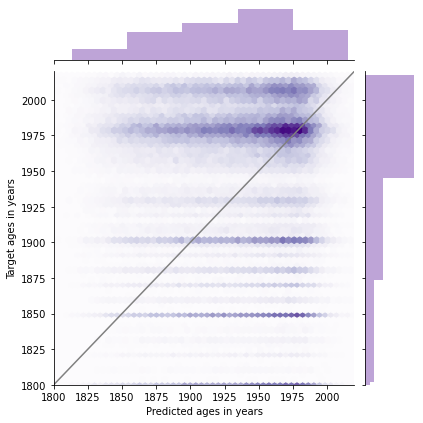

In [134]:
fig = plt.figure()

g = sns.JointGrid(df_valid['y_predict'],df_valid['y_valid'], xlim=(1800, 2020), ylim=(1800, 2020))

g.plot_joint(plt.hexbin,  cmap="Purples", 
             gridsize=500, 
             extent=[0, np.max(df_valid['y_predict']), 0, np.max(df_valid['y_valid'])]
             )

g.ax_joint.plot([1800,2020], [1800,2020], color = 'grey', linewidth=1.5)

_ = g.ax_marg_x.hist(df_valid['y_predict'], color="tab:purple", alpha=.6)
#                        bins=np.arange(0, 20, 1))

_ = g.ax_marg_y.hist(df_valid['y_valid'], color="tab:purple", alpha=.6,
                       orientation="horizontal")
#                        bins=np.arange(0, 20, 1))

g.set_axis_labels('Predicted ages in years','Target ages in years')
plt.show()

In [138]:
ft_importance = pd.DataFrame.from_dict(model.get_booster().get_score(importance_type="gain"), columns=['importance'],orient='index')

In [144]:
ft_importance[0:15]

,importance
buildings_within_buffer_500,2012421.18
BlockElongation,1045971.22
BlockConvexity,756980.55
FootprintArea,980127.91
av_elongation_within_buffer_100,1227200.65
total_ft_area_within_buffer_100,526016.05
std_elongation_within_buffer_500,707499.73
StdBlockFootprintArea,306741.45
av_elongation_within_buffer_500,789066.87
total_ft_area_within_buffer_500,704159.71


## Removing outliers

In [207]:
df_input = pd.read_csv(path_input)
df_input = df_input[df_input.DATE_APP>1850]

C:\Users\miln\AppData\Local\Continuum\anaconda3\envs\building-database\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [152]:
# we lose 1.3M buildings
len(df_input)

726138

In [208]:
df_valid = df_input[df_input.departement==region_names[0]]
len(df_valid)

138969

In [209]:
df_valid.DATE_APP.std()

41.24742494787173

In [150]:
df_input = df_input[~df_input.index.isin(df_valid.index)]
len(df_input)

587169

In [154]:
df_input = shuffle(df_input,random_state=0)
df_valid = shuffle(df_valid,random_state=0)
X_train = df_input.drop(columns=aux_cols+other_attributes_cols+['DATE_APP'])
y_train = df_input[['DATE_APP']]
X_valid = df_valid.drop(columns=aux_cols+other_attributes_cols+['DATE_APP'])
y_valid = df_valid[['DATE_APP']]
print((X_train.shape,y_train.shape,X_valid.shape,y_valid.shape))

((726138, 58), (726138, 1), (138969, 58), (138969, 1))


In [155]:
model = xgboost.XGBRegressor()

In [156]:
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [157]:
y_predict = model.predict(X_valid)

In [158]:
print('MAE: {} y'.format(metrics.mean_absolute_error(y_valid,y_predict)))
print('RMSE: {} y'.format(np.sqrt(metrics.mean_squared_error(y_valid,y_predict))))
print('R2: {}'.format(metrics.r2_score(y_valid,y_predict)))

MAE: 23.906051975353428 y
RMSE: 32.100125695967066 y
R2: 0.3943483438334622


## Adding the other features

This time let's import the csv with all the data.

In [159]:
path_input = r'E:\first-exp\all.csv'

In [186]:
df_input = pd.read_csv(path_input)

C:\Users\miln\AppData\Local\Continuum\anaconda3\envs\building-database\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [187]:
len(df_input)

1815731

Let's remove all buildings that do not have one of our four variables (age/type/floor/height).

In [188]:
df_input = df_input.dropna(subset=other_attributes_cols+['DATE_APP'])
len(df_input)

849994

In [189]:
df_input = df_input[df_input.USAGE1 != 'Indifférencié']
len(df_input)

848429

Here we need to encode 'usage', which is a categorical variable, into multiple dummy variables.

In [190]:
one_hot_encoding = pd.get_dummies(df_input.USAGE1, prefix='usage')
one_hot_encoding

,usage_Agricole,usage_Annexe,usage_Commercial et services,usage_Industriel,usage_Religieux,usage_Résidentiel,usage_Sportif
1,0,0,0,0,0,1,0
7,0,0,0,0,0,1,0
8,0,1,0,0,0,0,0
9,0,1,0,0,0,0,0
10,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
1815723,0,0,1,0,0,0,0
1815724,0,0,0,0,0,1,0
1815725,0,0,0,0,0,1,0
1815726,0,0,0,0,0,1,0


In [191]:
df_input = df_input.drop(columns=['USAGE1'])
df_input = df_input.merge(one_hot_encoding,left_index=True,right_index=True)

In [192]:
df_input = df_input[df_input.DATE_APP>1850]
len(df_input)

723458

In [193]:
df_valid = df_input[df_input.departement==region_names[0]]
df_input = df_input[~df_input.index.isin(df_valid.index)]
df_input = shuffle(df_input,random_state=0)
df_valid = shuffle(df_valid,random_state=0)

In [206]:
df_valid.DATE_APP.std()

41.250985113285104

In [194]:
X_train = df_input.drop(columns=aux_cols+['DATE_APP'])
y_train = df_input[['DATE_APP']]
X_valid = df_valid.drop(columns=aux_cols+['DATE_APP'])
y_valid = df_valid[['DATE_APP']]
print((X_train.shape,y_train.shape,X_valid.shape,y_valid.shape))

((584777, 67), (584777, 1), (138681, 67), (138681, 1))


In [196]:
model = xgboost.XGBRegressor()

In [197]:
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [198]:
y_predict = model.predict(X_valid)

In [199]:
print('MAE: {} y'.format(metrics.mean_absolute_error(y_valid,y_predict)))
print('RMSE: {} y'.format(np.sqrt(metrics.mean_squared_error(y_valid,y_predict))))
print('R2: {}'.format(metrics.r2_score(y_valid,y_predict)))

MAE: 25.526019456860528 y
RMSE: 33.75890476185828 y
R2: 0.330252378985316


In [205]:
ft_importance = pd.DataFrame.from_dict(model.get_booster().get_score(importance_type="gain"), columns=['importance'],orient='index')
ft_importance[0:15]

,importance
av_elongation_within_buffer_500,572993.99
FootprintArea,485662.30
total_ft_area_within_buffer_100,336938.73
std_convexity_within_buffer_100,42443.17
Phi,339352.64
BlockConvexity,350944.60
HAUTEUR,98762.38
std_block_footprint_area_within_buffer_100,414194.66
av_block_length_within_buffer_100,139533.62
total_ft_area_within_buffer_500,139883.58
